# Analyzing the Results
Fitting was done in another notebook. This one demonstrates a few different ways to visualize & look at the results.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import arviz
import ipywidgets
from matplotlib import cm, pyplot
import numpy
import os
import pandas
import pathlib
import pymc3
import xarray

import cutisplit
import run_analysis

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [3]:
RUN_ID = "BPXWDB"
analyser = run_analysis.CutisplitAnalysis(RUN_ID)
resultpath = f'{RUN_ID}_Results' 
if not os.path.isdir(resultpath):
    os.makedirs(resultpath)

In [4]:
idata = arviz.from_netcdf(fr"{resultpath}\{RUN_ID}_result.nc")
idata

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data
	> constant_data

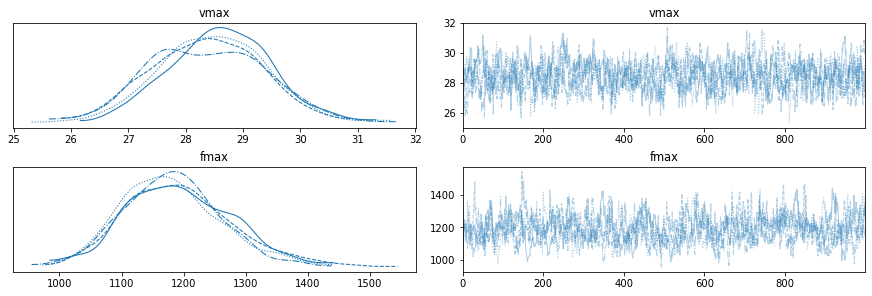

In [5]:
# For every "type" there is a vmax and fmax result:
arviz.plot_trace(idata, var_names=["vmax", "fmax"]);
# The left subplots show the posterior probability density.
# The right subplots show the MCMC. If they look like random noise everything is fine.
# The linestyle corresponds to independent MCMC chains - they should come to the same result.

In [6]:
# The split-GFP assay is more interesting:
# It has nice saturation kinetics and can suffer from fluorescence decay.
cutisplit.plot_sgfp_fit_interactive(idata);

interactive(children=(Dropdown(description='sample_type', options=('reference',), value='reference'), Dropdown…

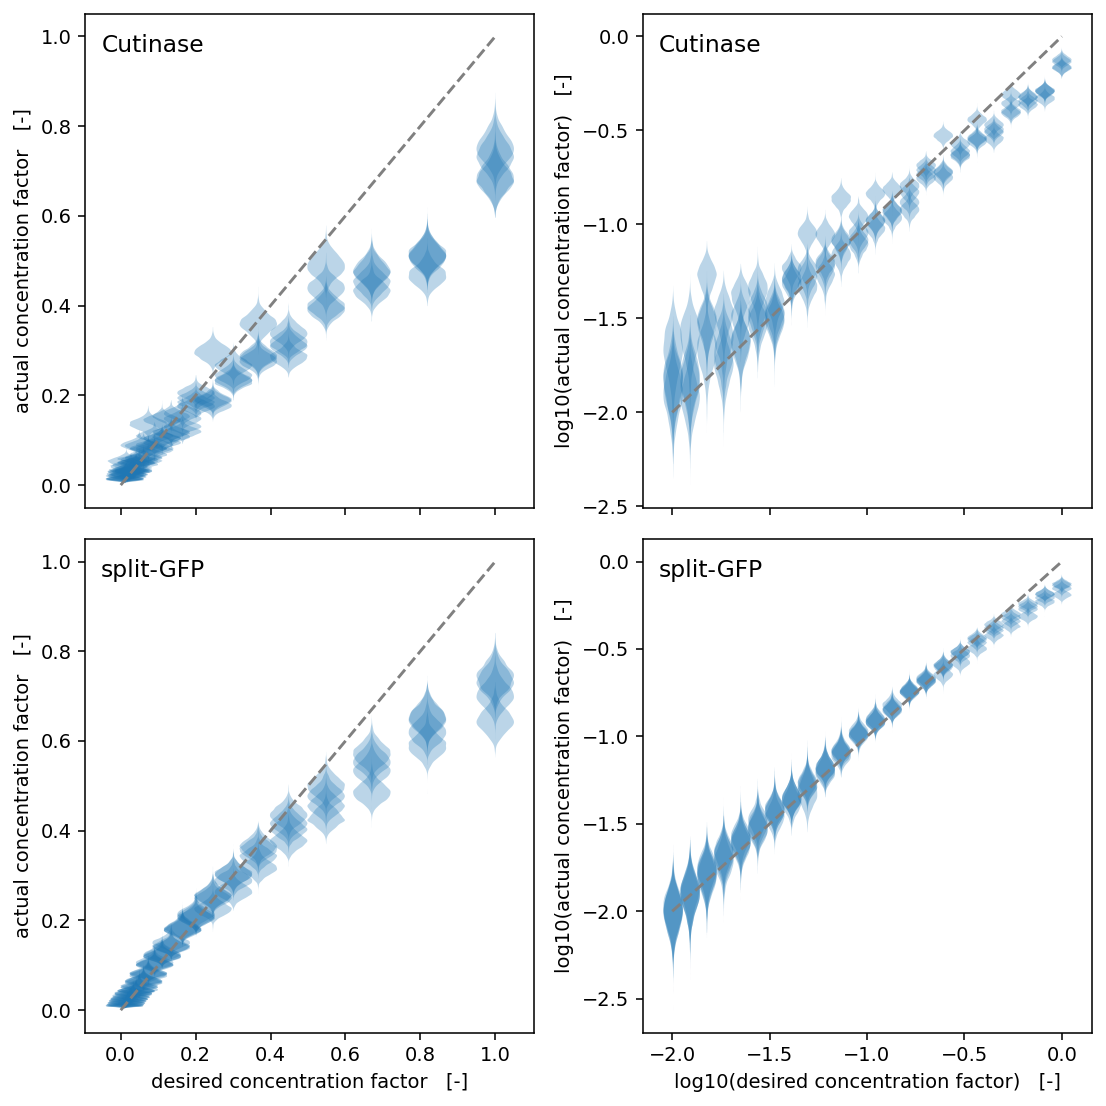

In [7]:
cutisplit.plot_concentration_error(idata);

In [8]:
arviz.summary(idata, var_names=["cf_cutinase_assay", "cf_sgfp_assay"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
cf_cutinase_assay[0],0.687,0.030,0.629,0.744,0.001,0.001,750.0,1879.0,1.01
cf_cutinase_assay[1],0.206,0.012,0.185,0.227,0.000,0.000,1360.0,2428.0,1.00
cf_cutinase_assay[2],0.058,0.006,0.048,0.069,0.000,0.000,3475.0,3281.0,1.00
cf_cutinase_assay[3],0.681,0.029,0.627,0.734,0.001,0.001,596.0,1612.0,1.01
cf_cutinase_assay[4],0.176,0.010,0.158,0.195,0.000,0.000,1093.0,2535.0,1.00
...,...,...,...,...,...,...,...,...,...
cf_sgfp_assay[91],0.049,0.009,0.033,0.065,0.000,0.000,4784.0,3058.0,1.00
cf_sgfp_assay[92],0.010,0.002,0.006,0.014,0.000,0.000,6986.0,2756.0,1.00
cf_sgfp_assay[93],0.255,0.014,0.230,0.283,0.000,0.000,1243.0,1887.0,1.01
cf_sgfp_assay[94],0.053,0.007,0.041,0.066,0.000,0.000,3886.0,3124.0,1.00


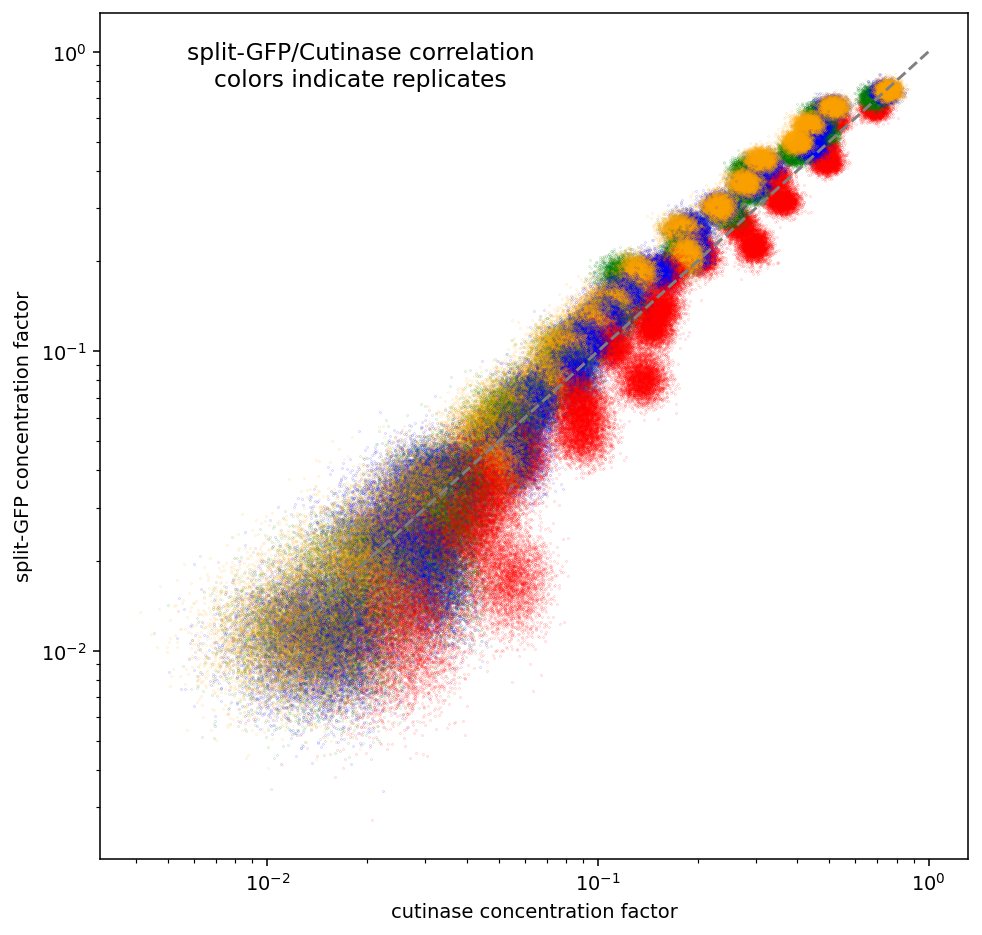

In [9]:
posterior = idata.posterior.stack(sample=("chain", "draw"))
fig, axs = pyplot.subplots(dpi=140, figsize=(8,8))

cf_input = idata.constant_data.cf_input.values
for c, cf in enumerate(numpy.sort(numpy.unique(cf_input))[::-1]):
    iwells = idata.constant_data.input_well[cf_input == cf].values
    awells = cutisplit.replicate_wells_from(iwells)
    for awell, color in zip(awells, ["red", "green", "blue", "orange"]):
        samples_x = posterior.cf_cutinase_assay.sel(assay_well=awell).values
        samples_y = posterior.cf_sgfp_assay.sel(assay_well=awell).values
        axs.scatter(
            samples_x, samples_y,
            marker=".", color=color,
            s=0.02
        )
axs.plot([0.01,1], [0.01,1], color="gray", linestyle="--")
axs.set_xlabel("cutinase concentration factor")
axs.set_ylabel("split-GFP concentration factor")
axs.set_xscale("log")
axs.set_yscale("log")
axs.set_title("split-GFP/Cutinase correlation\ncolors indicate replicates", x=0.3, y=0.9)
# red     original input  e.g. A01
# green   copied input    e.g. A04
# blue    copy of red     e.g. A07
# orange  copy of green   e.g. A10
#pyplot.savefig(fr"{resultpath}\{RUN_ID}_sGFP-cutinase-correlation.png", dpi=120)
pyplot.show()